Final Sharpe: 0.006451735964962931


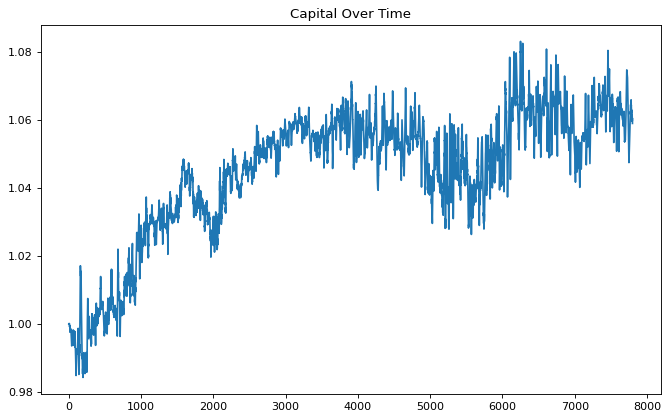

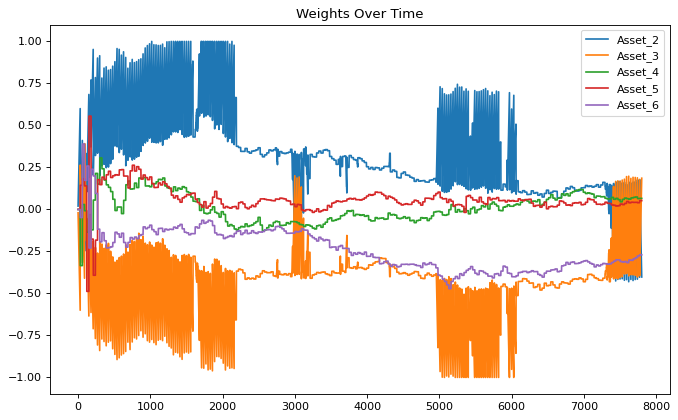

In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

# =================
# Load data
# =================
data = pd.read_csv('Case2.csv', index_col=0)

# Example train-test split
TRAIN, TEST = train_test_split(data, test_size=0.2, shuffle=False)

# =================
# Helper functions
# =================

def compute_returns(price_df):
    """
    Given a price DataFrame, return the daily returns DataFrame.
    (For intraday, you can similarly compute returns at the tick level.)
    """
    return price_df.pct_change().dropna(how="all")

def markowitz_weights(returns_df):
    """
    Simple Markowitz weight computation using historical returns & covariance.
    - We'll do the classical formula: w ~ Sigma^{-1} mu
    - We'll then normalize so sum of weights = 1, and clip to [-1, 1] for the competition constraints.
    """

    # Estimate expected returns (mean of historical returns)
    mu = returns_df.mean().values  # shape (6,)

    # Estimate covariance
    Sigma = returns_df.cov().values  # shape (6,6)

    # Pseudo-inverse in case Sigma is singular or nearly singular
    # (In real code, you might do some regularization here.)
    inv_Sigma = np.linalg.pinv(Sigma)

    # Markowitz: w ~ inv_Sigma * mu
    raw_weights = inv_Sigma @ mu

    # Normalize to sum of weights = 1
    if np.sum(np.abs(raw_weights)) > 0:
        weights = raw_weights / np.sum(np.abs(raw_weights))
    else:
        # fallback
        weights = np.ones_like(mu) / len(mu)

    # Clip each weight to [-1, 1]
    weights = np.clip(weights, -1, 1)

    return weights

def simple_pairs_adjustment(prices_vector, pairs_indices=(1,2), threshold=0.01):
    """
    Very naive pairs-trading adjustment:
    - pairs_indices is a tuple (i, j) for two assets you think are correlated.
    - If their relative return diverges beyond threshold, add a small offset to the relevant positions.
    - This is just an example; in reality, you'd keep more sophisticated intraday stats.
    """
    i, j = pairs_indices
    # Suppose we define the ratio or difference:
    # ratio = price_j / price_i from the previous day to today
    # But here we only have "today's" prices in allocate_portfolio.
    # In practice, you'd track the last price and compare to today's, etc.

    # For demonstration, let's do a random small adjustment based on
    # the difference in their prices (this is not truly pairs-trading logic).
    price_i = prices_vector[i]
    price_j = prices_vector[j]

    # If they diverge by more than threshold fraction, tilt slightly
    diff_fraction = abs(price_j - price_i) / ((price_i + price_j)/2.0 + 1e-8)

    if diff_fraction > threshold:
        # Example: overweight the cheaper one, underweight the more expensive
        if price_i < price_j:
            return (0.02, -0.02)  # i up, j down
        else:
            return (-0.02, 0.02)
    else:
        return (0.0, 0.0)

# =================
# Allocator class
# =================

class Allocator():
    def __init__(self, train_data):
        """
        Any data you want to store between days must be stored in a class field.
        """
        # We'll store the running price paths here
        self.running_price_paths = train_data.copy()
        self.train_data = train_data.copy()

        # The "current" weights we hold. Initialize to something neutral.
        # We'll update these once per day in Markowitz, and tweak intraday as needed.
        self.current_weights = np.zeros(train_data.shape[1])

        # Keep track of how many ticks have passed in the out-of-sample test period
        self.ticks_seen = 0

        # We’ll store the last day index we ran Markowitz on,
        # so that we only update once per day in this example
        # (30 ticks per day in the sample data).
        self.last_markowitz_day = -1

    def allocate_portfolio(self, asset_prices):
        """
        asset_prices: np array of length 6, prices of the 6 assets at this particular tick.
        weights:      np array of length 6, portfolio allocation for the *next* day (or next tick).
        """
        # 1) Append the new price row
        #    We do this so we can compute rolling returns etc. when it hits the next "day boundary."
        new_index = len(self.running_price_paths)  # next row index
        self.running_price_paths.loc[new_index] = asset_prices

        # 2) Check if we are at a day boundary (for example, every 30 ticks).
        #    If so, we do a Markowitz update using daily returns.
        day_index = self.ticks_seen // 30  # integer day counter
        if day_index != self.last_markowitz_day:
            # It's a new day, so we recompute Markowitz weights.
            # For demonstration, let's compute daily returns over all data so far.
            historical_prices = self.running_price_paths.copy()
            # Convert intraday ticks to daily "close" or daily return. For simplicity, 
            # we'll just use the last tick each day as the daily close.
            # A rough approach: group every 30 rows = 1 day, take the last row as "close."
            # This is simplistic but enough for an illustration.
            daily_closes = historical_prices.groupby(
                by=(historical_prices.index // 30)
            ).last()

            # Compute daily returns
            daily_returns = compute_returns(daily_closes)

            # Use Markowitz formula
            if len(daily_returns) > 1:
                # Only do Markowitz if we have enough data
                self.current_weights = markowitz_weights(daily_returns)
            else:
                # Otherwise, fallback
                self.current_weights = np.zeros(historical_prices.shape[1])

            # Update the last_markowitz_day tracker
            self.last_markowitz_day = day_index

        # 3) (Optional) Intraday pairs-trading tweak.
        #    Let’s do a trivial example with Assets 1 and 2.
        #    This can be done every tick if desired.
        pairs_delta_i, pairs_delta_j = simple_pairs_adjustment(
            asset_prices,
            pairs_indices=(0, 1),
            threshold=0.02  # Adjust threshold as you like
        )
        # Add these small offset adjustments to the baseline Markowitz
        self.current_weights[0] += pairs_delta_i
        self.current_weights[1] += pairs_delta_j

        # Clip the weights each time to maintain [-1,1]
        self.current_weights = np.clip(self.current_weights, -1, 1)

        # 4) Increase tick counter
        self.ticks_seen += 1

        # 5) Return the new allocation
        return self.current_weights


# =================
# Grading Function
# =================

def grading(train_data, test_data):
    """
    Grading script
    """
    weights = np.full(shape=(len(test_data), train_data.shape[1]), fill_value=0.0)
    alloc = Allocator(train_data)

    for i in range(len(test_data)):
        w = alloc.allocate_portfolio(test_data.iloc[i, :].values)
        weights[i, :] = w
        # Check constraints
        if np.any(w < -1) or np.any(w > 1):
            raise Exception("Weights outside of [-1, 1].")

    # Calculate capital path
    capital = [1]
    for i in range(len(test_data) - 1):
        # How many shares we hold for each asset
        shares = capital[-1] * weights[i] / np.array(test_data.iloc[i, :])
        # Money left after buying those shares
        balance = capital[-1] - np.dot(shares, np.array(test_data.iloc[i, :]))
        # Value of those shares at the next tick’s prices
        net_change = np.dot(shares, np.array(test_data.iloc[i+1, :]))
        # Next capital
        capital.append(balance + net_change)

    capital = np.array(capital)
    returns = (capital[1:] - capital[:-1]) / capital[:-1]
    # Simple Sharpe ratio (assume risk-free rate ~ 0 for competition)
    if np.std(returns) != 0:
        sharpe = np.mean(returns) / np.std(returns)
    else:
        sharpe = 0
    return sharpe, capital, weights

# =================
# Run the strategy
# =================

sharpe, capital, weights = grading(TRAIN, TEST)
print("Final Sharpe:", sharpe)

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Capital Over Time")
plt.plot(np.arange(len(TEST)), capital)
plt.show()

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Weights Over Time")
plt.plot(np.arange(len(TEST)), weights)
plt.legend(TEST.columns)
plt.show()


Markowitz Approach Sharpe: 0.0029


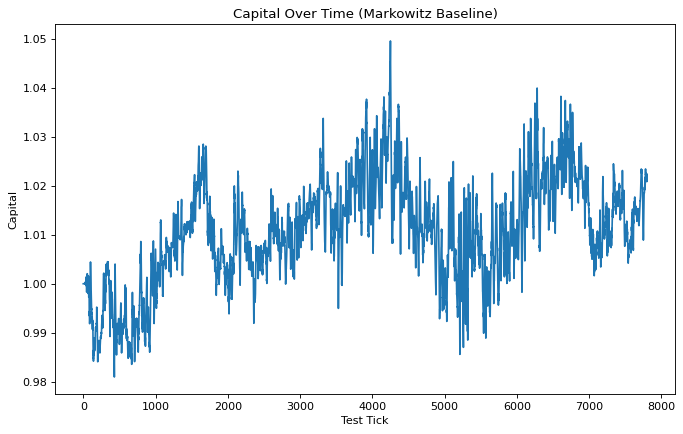

Risk Parity Approach Sharpe: 0.0038


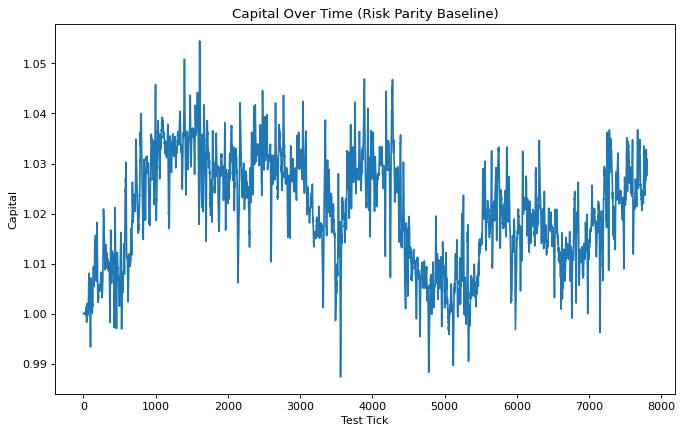

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

###############################################################################
# 1) Load Data
###############################################################################
# Adjust path as needed
DATA_PATH = 'Case2.csv'
full_data = pd.read_csv(DATA_PATH)

###############################################################################
# 2) Split Data into Train / Test
###############################################################################
train_size = int(0.8 * len(full_data))
train_data = full_data.iloc[:train_size].copy()
test_data  = full_data.iloc[train_size:].copy()

###############################################################################
# 3) Helper Functions
###############################################################################
def compute_daily_closes(intraday_df, ticks_per_day=30):
    """
    Convert intraday data (with 'ticks_per_day' ticks per day) into daily closes.
    Groups rows by day index = row_index // ticks_per_day.
    """
    df = intraday_df.copy()
    df['DayIndex'] = df.index // ticks_per_day
    daily_closes = df.groupby('DayIndex').last()
    return daily_closes


def compute_returns(price_df):
    """
    Simple returns: r_t = (p_t / p_{t-1}) - 1
    """
    return price_df.pct_change().dropna(how='any')

def uniform_scale_to_bounds(weights, bound=1.0):
    """
    Uniformly scale weights so that max(|w_i|) <= bound.
    We do NOT clip individually; instead we find the largest absolute weight
    and scale *all* weights if necessary.
    """
    max_abs_w = np.max(np.abs(weights))
    if max_abs_w > bound:
        return weights / max_abs_w * bound
    else:
        return weights

###############################################################################
# A) Markowitz and Risk Parity Functions
###############################################################################
def markowitz_weights(daily_returns, lambda_reg=0.01, sum_abs_target=1.0):
    """
    A simple Markowitz approach:
    w_raw = inv(Sigma + lambda*I) * mu
    Then we scale so that sum of abs(w_raw) = sum_abs_target (optional),
    and then do a final uniform scaling to ensure max(|w|) <= 1.
    """
    mu = daily_returns.mean().values  # shape (n,)
    Sigma = daily_returns.cov().values
    n = Sigma.shape[0]

    # Regularize
    Sigma_reg = Sigma + lambda_reg * np.eye(n)
    inv_Sigma = np.linalg.pinv(Sigma_reg)

    # Raw Markowitz
    w_raw = inv_Sigma @ mu

    # Scale sum(abs(w)) = sum_abs_target
    sum_abs = np.sum(np.abs(w_raw))
    if sum_abs > 1e-9:
        w_scaled = (w_raw / sum_abs) * sum_abs_target
    else:
        w_scaled = np.ones(n) / n

    # Final uniform scaling to ensure max(|w|) <= 1
    w_final = uniform_scale_to_bounds(w_scaled, bound=1.0)
    return w_final

def risk_parity_weights(daily_returns, max_iter=100, tol=1e-6, sum_weights=1.0):
    """
    Simple iterative "long-only" risk parity solver that ensures:
      w_i * [Sigma w]_i is the same for all i (equal risk contribution).
    Then we do a final uniform scaling to ensure max(|w|) <= 1.

    If you want partial short exposures, you'd need more advanced logic,
    but we'll keep it straightforward. We'll still do a "nonnegative" approach
    and then unify-scale to [-1,1] at the end.
    """
    Sigma = daily_returns.cov().values
    n = Sigma.shape[0]

    # Start with an equal weighting
    w = np.ones(n) / n

    for iteration in range(max_iter):
        w_old = w.copy()

        # Sigma * w
        Sigma_w = Sigma @ w
        total_risk = np.sum(w * Sigma_w)  # sum_i( w_i * (Sigma w)_i )
        if total_risk < 1e-9:
            break

        # Update each coordinate
        for i in range(n):
            rc_i = w[i] * Sigma_w[i]  # risk contribution of asset i
            target_rc = total_risk / n
            if rc_i > 1e-12:
                # multiplicative update (Newton step)
                w[i] *= np.sqrt(target_rc / rc_i)
            else:
                w[i] *= 1.0

        # Renormalize to sum of weights = sum_weights
        s = w.sum()
        if s > 1e-9:
            w *= sum_weights / s

        # check convergence
        if np.linalg.norm(w - w_old) < tol:
            break

    # Now we have long-only w in [0, ...], sum(w)=1. 
    # If the competition allows shorting, we do a final uniform scaling to ensure max(|w|) <= 1.
    # That means some weights might remain 0, but let's keep it a standard approach:
    w_final = uniform_scale_to_bounds(w, bound=1.0)
    return w_final

###############################################################################
# B) More Sophisticated Pairs Trading
###############################################################################
class PairsTrader:
    """
    Tracks an intraday rolling ratio for a pair of assets (i, j). 
    If ratio is above (mean + X stdev), short the pair. If below (mean - X stdev), long the pair.

    We'll store a rolling window of ratios in a small deque or list, 
    and each time we get a new price, we update the ratio array, 
    recompute mean & stdev, and decide on a "tilt" to apply.
    """
    def __init__(self, i=0, j=1, window_size=60, z_thresh=2.0, tilt_size=0.05):
        """
        i, j: indices of assets to trade in pair
        window_size: how many ticks to store in rolling window
        z_thresh: # of stdev from mean to trigger a trade
        tilt_size: how large the tilt is in absolute terms (like 0.05 => 5% extra position)
        """
        self.i = i
        self.j = j
        self.window_size = window_size
        self.z_thresh = z_thresh
        self.tilt_size = tilt_size

        # Rolling memory of ratio = price_j / price_i
        self.ratios = []

    def get_tilt(self, prices):
        """
        1) Update the rolling ratio array
        2) Compute mean, stdev
        3) If ratio > mean + z_thresh*stdev => short j, long i
           If ratio < mean - z_thresh*stdev => long j, short i
        4) Return a tuple (delta_i, delta_j)
        """
        p_i = prices[self.i]
        p_j = prices[self.j]

        # Avoid dividing by zero
        if p_i < 1e-9:
            ratio = 1.0  # fallback
        else:
            ratio = p_j / p_i
        
        # Update rolling buffer
        self.ratios.append(ratio)
        if len(self.ratios) > self.window_size:
            self.ratios.pop(0)

        # Need enough data to do anything
        if len(self.ratios) < 2:
            return (0.0, 0.0)

        arr = np.array(self.ratios)
        mean_r = arr.mean()
        std_r  = arr.std()

        if std_r < 1e-9:
            # no variation => no trade
            return (0.0, 0.0)

        # current dev in z-scores
        z = (ratio - mean_r) / std_r

        # basic logic:
        if z > self.z_thresh:
            # ratio is too high => p_j is "expensive" vs p_i => short j, long i
            return (+self.tilt_size, -self.tilt_size)
        elif z < -self.z_thresh:
            # ratio is too low => p_j is "cheap" vs p_i => long j, short i
            return (-self.tilt_size, +self.tilt_size)
        else:
            return (0.0, 0.0)

###############################################################################
# C) Allocator Class
###############################################################################
class Allocator:
    def __init__(self, train_data, method='markowitz'):
        """
        method: either 'markowitz' or 'risk_parity'
        We'll compute daily baseline with one of these.
        """
        self.method = method
        self.running_price_paths = pd.DataFrame(columns=train_data.columns)
        self.train_data = train_data.copy()

        # We'll keep track of the day index to rebalance daily
        self.tick_count = 0
        self.last_rebalance_day = -1

        # Current baseline weights
        self.current_weights = np.zeros(train_data.shape[1])

        # Some hyperparameters
        self.lookback_days = 200   # how many days for rolling covariance or risk
        self.lambda_reg = 0.01    # Markowitz regularization

        # Initialize the pairs trader
        #   We pick the first two assets for demonstration. Adjust as you wish.
        self.pairs_trader = PairsTrader(
            i=0, j=1,  # or pick any pair
            window_size=60, 
            z_thresh=2.0, 
            tilt_size=0.05
        )

    def allocate_portfolio(self, prices):
        """
        Called each tick with current prices (array of length n_assets).
        Returns the weight vector for the *next* tick.
        """
        # 1) Append new row to running price path
        idx = len(self.running_price_paths)
        self.running_price_paths.loc[idx] = prices

        # 2) Check if we're in a new day => daily rebalance
        current_day = self.tick_count // 30  # 30 ticks/day
        if current_day != self.last_rebalance_day:
            # We compute daily closes so far
            daily_closes = compute_daily_closes(self.running_price_paths, ticks_per_day=30)
            daily_rets   = compute_returns(daily_closes)
            # Use a rolling window of lookback_days
            if len(daily_rets) > self.lookback_days:
                recent_rets = daily_rets.iloc[-self.lookback_days:]
            else:
                recent_rets = daily_rets

            if len(recent_rets) < 2:
                # fallback if not enough data
                new_baseline = np.zeros(len(prices))
            else:
                # compute either markowitz or risk parity
                if self.method == 'markowitz':
                    new_baseline = markowitz_weights(
                        recent_rets, 
                        lambda_reg=self.lambda_reg, 
                        sum_abs_target=1.0
                    )
                elif self.method == 'risk_parity':
                    new_baseline = risk_parity_weights(
                        recent_rets, 
                        max_iter=200, 
                        tol=1e-7, 
                        sum_weights=1.0
                    )
                else:
                    new_baseline = np.zeros(len(prices))

            self.current_weights = new_baseline
            self.last_rebalance_day = current_day

        # 3) Intraday pairs trading tilt
        d_i, d_j = self.pairs_trader.get_tilt(prices)
        self.current_weights[self.pairs_trader.i] += d_i
        self.current_weights[self.pairs_trader.j] += d_j

        # 4) Uniformly scale so that max(|w|) <= 1
        self.current_weights = uniform_scale_to_bounds(self.current_weights, bound=1.0)

        # 5) increment tick_count
        self.tick_count += 1

        # Return the final weights
        return self.current_weights

###############################################################################
# D) Grading / Backtest Function
###############################################################################
def grading(train_df, test_df, method='markowitz'):
    """
    1) Instantiate Allocator(method=...) 
    2) For each row in test_df, get weights
    3) Compute capital evolution, Sharpe
    """
    n_assets = train_df.shape[1]
    n_ticks  = len(test_df)
    weights_history = np.zeros((n_ticks, n_assets))

    # Create the allocator with chosen method
    alloc = Allocator(train_df, method=method)

    # 1) Retrieve weights for each tick
    for i in range(n_ticks):
        prices_i = test_df.iloc[i, :].values
        w_i = alloc.allocate_portfolio(prices_i)
        weights_history[i, :] = w_i
        # Check bounds
        if np.any(np.abs(w_i) > 1):
            raise ValueError("Weight out of [-1,1] bound")

    # 2) Compute capital path
    capital = [1.0]
    for i in range(n_ticks - 1):
        current_prices = test_df.iloc[i, :].values
        next_prices    = test_df.iloc[i+1, :].values
        w = weights_history[i, :]

        # number of shares we hold
        shares = (capital[-1] * w) / current_prices
        # leftover balance after buying shares
        balance = capital[-1] - np.dot(shares, current_prices)
        # next capital from shares + leftover
        new_cap = balance + np.dot(shares, next_prices)
        capital.append(new_cap)

    capital = np.array(capital)
    returns = (capital[1:] - capital[:-1]) / capital[:-1]
    avg_ret = np.mean(returns)
    vol     = np.std(returns)
    sharpe  = 0.0 if vol < 1e-12 else (avg_ret / vol)

    return sharpe, capital, weights_history

###############################################################################
# E) Run Both Approaches & Plot
###############################################################################

# Markowitz approach
sharpe_m, capital_m, weights_m = grading(train_data, test_data, method='markowitz')
print(f"Markowitz Approach Sharpe: {sharpe_m:.4f}")

plt.figure(figsize=(10,6), dpi=80)
plt.title("Capital Over Time (Markowitz Baseline)")
plt.plot(capital_m)
plt.xlabel("Test Tick")
plt.ylabel("Capital")
plt.show()

# Risk Parity approach
sharpe_rp, capital_rp, weights_rp = grading(train_data, test_data, method='risk_parity')
print(f"Risk Parity Approach Sharpe: {sharpe_rp:.4f}")

plt.figure(figsize=(10,6), dpi=80)
plt.title("Capital Over Time (Risk Parity Baseline)")
plt.plot(capital_rp)
plt.xlabel("Test Tick")
plt.ylabel("Capital")
plt.show()


In [7]:
def plot_weights(weights_matrix, asset_names, title="Portfolio Weights Over Time"):
    """
    Plots each asset's weight over time.
    
    Parameters:
    - weights_matrix: numpy array of shape (n_ticks, n_assets)
    - asset_names: list of asset column names
    - title: plot title
    """
    plt.figure(figsize=(12, 6), dpi=100)
    for i in range(weights_matrix.shape[1]):
        plt.plot(weights_matrix[:, i], label=asset_names[i])
    plt.title(title)
    plt.xlabel("Tick")
    plt.ylabel("Weight")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

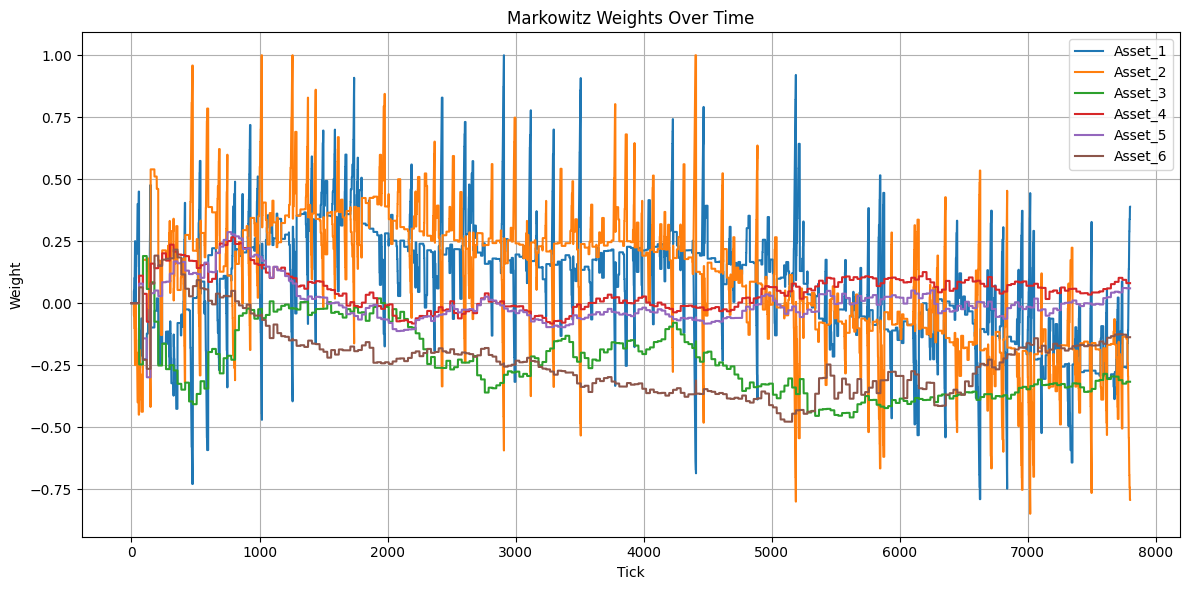

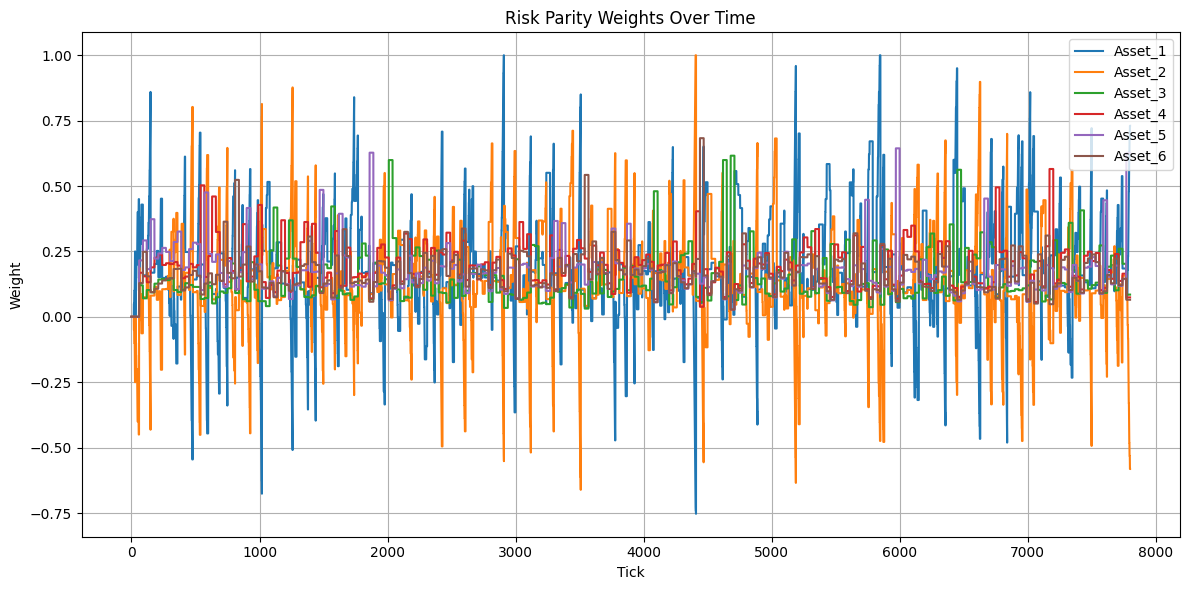

In [8]:
# Plot Markowitz weights
plot_weights(weights_m, asset_names=test_data.columns, title="Markowitz Weights Over Time")

# Plot Risk Parity weights
plot_weights(weights_rp, asset_names=test_data.columns, title="Risk Parity Weights Over Time")
